# Fake News Detection : ISOT

In [5]:
#!pip install wordcloud
#!pip install nltk


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [5]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.15.2-py3-none-any.whl.metadata (15 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached cloudpathlib-0.21.0-py3-none-any.whl.metadata (14 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata

In [6]:
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
# Importation des bibliothèques nécessaires
import os
import pickle
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy.cli
spacy.cli.download("en_core_web_sm")


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
def load_isot_dataset(fake_file, true_file):
    """Charge les fichiers de données et retourne un DataFrame pour les données de fausses et vraies nouvelles."""
    fake_data = pd.read_csv(fake_file)
    true_data = pd.read_csv(true_file)
    
    fake_data['label'] = 0  # Label 0 pour les fausses nouvelles
    true_data['label'] = 1  # Label 1 pour les vraies nouvelles
    
    return pd.concat([fake_data, true_data], ignore_index=True)

# Exemple de chargement de données
train_data = load_isot_dataset("data/Fake.csv", "data/True.csv")

# Diviser les données en caractéristiques (X) et labels (y)
X = train_data["text"]  # Le texte des articles
y = train_data["label"]  # Les labels (0 ou 1)

### Retrieve, format and describe the data statistically

In [8]:
# Afficher les premières lignes du DataFrame
print(train_data.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


In [ ]:
# Statistiques descriptives de base
def describe_data(df):
    """Affiche les statistiques descriptives et des informations sur les données."""
    # Afficher les informations générales sur le DataFrame
    print("\nInfo générale sur les données :")
    print(df.info())
    
    # Afficher les statistiques descriptives des données textuelles
    print("\nStatistiques descriptives des données :")
    print(df.describe())

    # Vérifier les valeurs manquantes
    missing_data = df.isnull().sum()
    print("\nValeurs manquantes :")
    print(missing_data)

    # Répartition des classes (fake vs real)
    class_counts = df['label'].value_counts()
    print("\nRépartition des classes :")
    print(class_counts)

    # Distribution de la longueur des articles (en nombre de mots)
    df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))  # Calcul de la longueur en mots
    print("\nStatistiques sur la longueur des articles :")
    print(df['text_length'].describe())
    
    # Visualisation de la distribution de la longueur des articles
    plt.figure(figsize=(10,6))
    sns.histplot(df['text_length'], bins=50, kde=True)
    plt.title('Distribution de la longueur des articles')
    plt.xlabel('Nombre de mots')
    plt.ylabel('Fréquence')
    plt.show()


Info générale sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        44898 non-null  object
 1   text         44898 non-null  object
 2   subject      44898 non-null  object
 3   date         44898 non-null  object
 4   label        44898 non-null  int64 
 5   text_length  44898 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.1+ MB
None

Statistiques descriptives des données :
              label   text_length
count  44898.000000  44898.000000
mean       0.477015    405.282284
std        0.499477    351.265595
min        0.000000      0.000000
25%        0.000000    203.000000
50%        0.000000    362.000000
75%        1.000000    513.000000
max        1.000000   8135.000000

Valeurs manquantes :
title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype

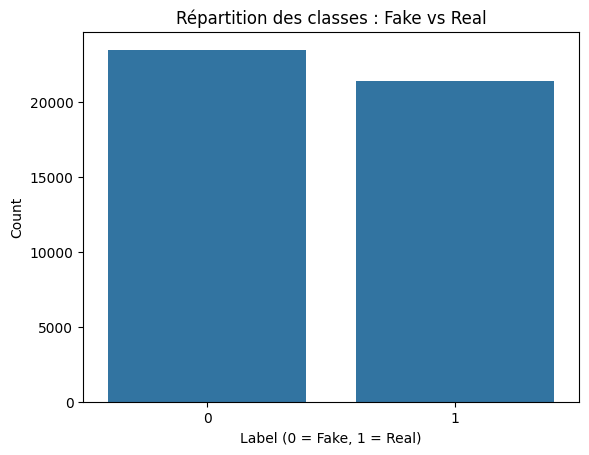


Statistiques sur la longueur des articles :
count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: text_length, dtype: float64


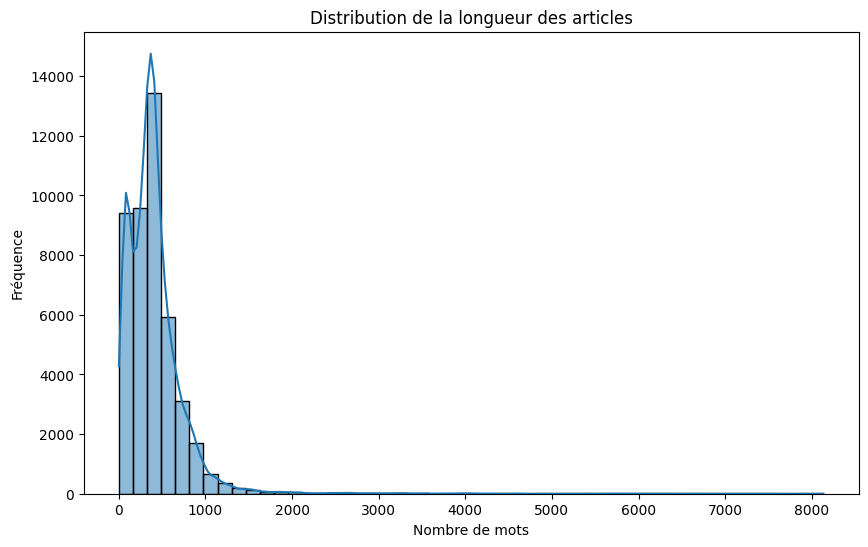

In [12]:
# Exécution de la fonction de description
describe_data(train_data)

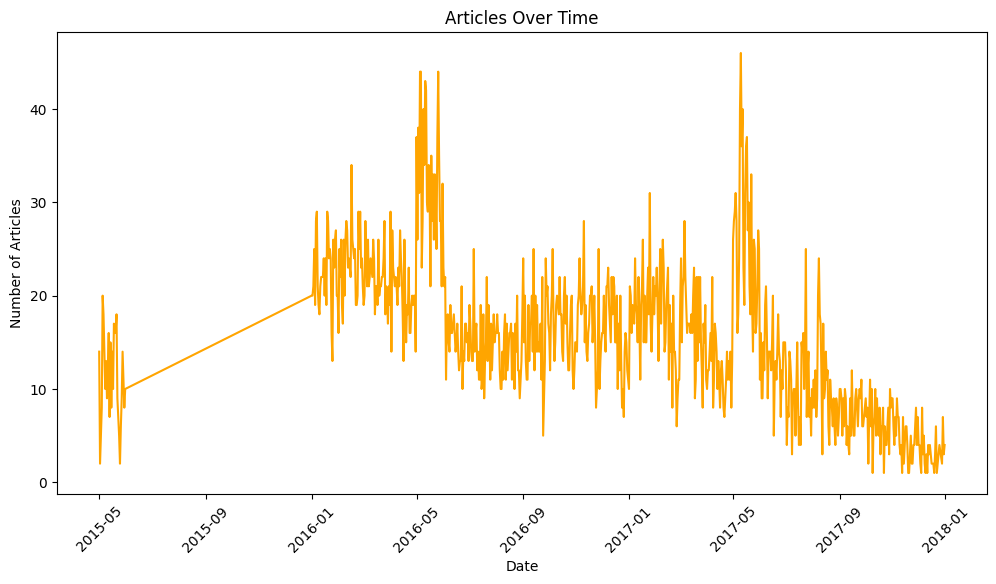

In [15]:
# Convertir la colonne 'date' en format datetime
train_data['date'] = pd.to_datetime(train_data['date'], errors='coerce')

# Compter les articles par date
articles_by_date = train_data.groupby(train_data['date'].dt.date).size()

# Visualiser l'évolution des articles dans le temps
plt.figure(figsize=(12, 6))
plt.plot(articles_by_date.index, articles_by_date.values, color='orange')
plt.title('Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

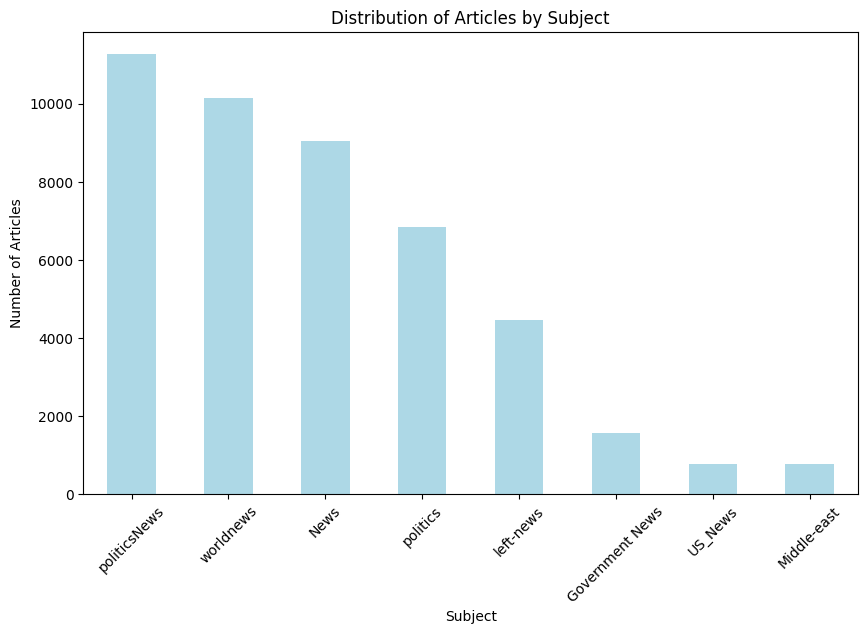

In [16]:
# Répartition des articles par sujet
subject_counts = train_data['subject'].value_counts()

plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar', color='lightblue')
plt.title('Distribution of Articles by Subject')
plt.xlabel('Subject')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()


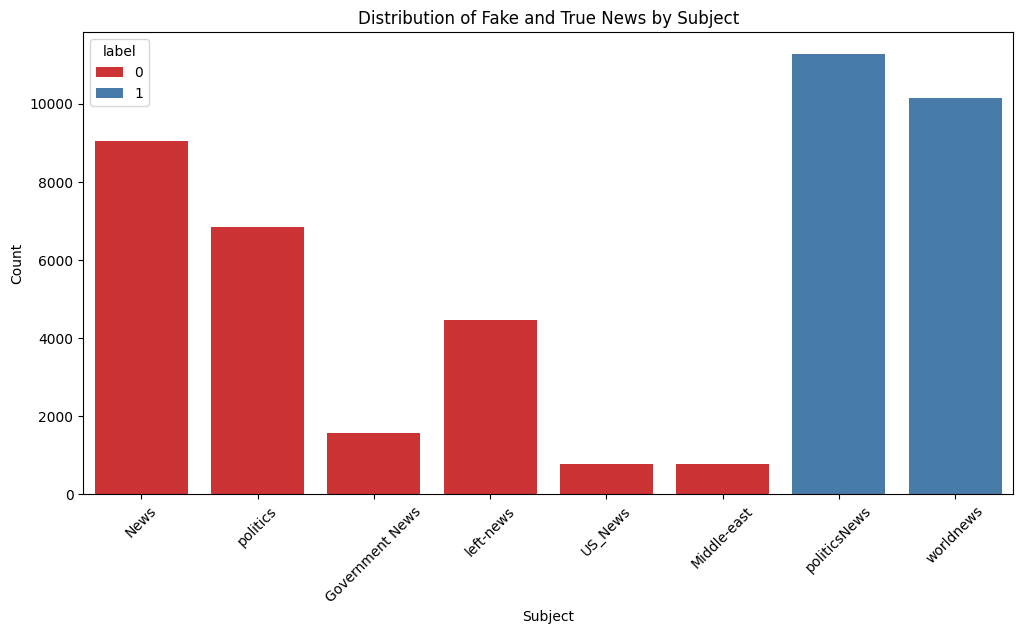

In [17]:
# Répartition des classes par sujet
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', hue='label', data=train_data, palette='Set1')
plt.title('Distribution of Fake and True News by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

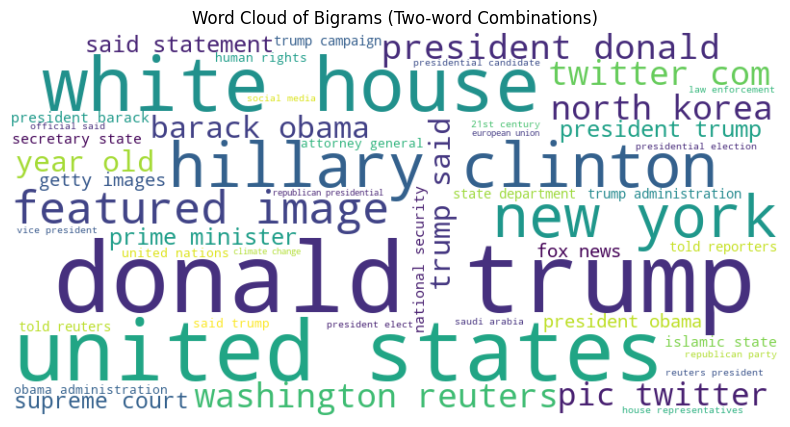

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Extraire des bigrammes
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=50)
bigrams = vectorizer.fit_transform(train_data['text'])

# Créer un word cloud pour les bigrammes
bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigrams.sum(axis=0).A1))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Bigrams (Two-word Combinations)")
plt.show()

Ici, pour faire un Word Cloud cohérent, on enlève les stop_words et on lemmatize à la racine.

In [30]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pandas as pd
from tqdm import tqdm

# Charger le modèle spaCy en désactivant les composants inutiles
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Fonction de prétraitement en batch avec nlp.pipe()
def preprocess_batch(texts, batch_size=50, max_length=2000):
    processed_texts = []
    for doc in nlp.pipe((text[:max_length].lower() for text in texts), batch_size=batch_size):
        processed_texts.append(" ".join(token.lemma_ for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation))
    return processed_texts

# Charger les données (exemple avec un DataFrame)
# train_data = pd.read_csv("chemin_vers_fichier.csv")

# Afficher une barre de progression avec tqdm
tqdm.pandas()

# Appliquer le prétraitement sur la colonne 'text'
train_data["processed_text"] = preprocess_batch(train_data["text"].tolist())

# Vérifier les résultats
print(train_data[["text", "processed_text"]].head())

                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annual Christmas Day mes...   

                                      processed_text  
0  donald trump couldn t wish americans happy new...  
1  house intelligence committee chairman devin nu...  
2  friday reveal milwaukee sheriff david clarke c...  
3  christmas day donald trump announce   work   f...  
4  pope francis annual christmas day message rebu...  


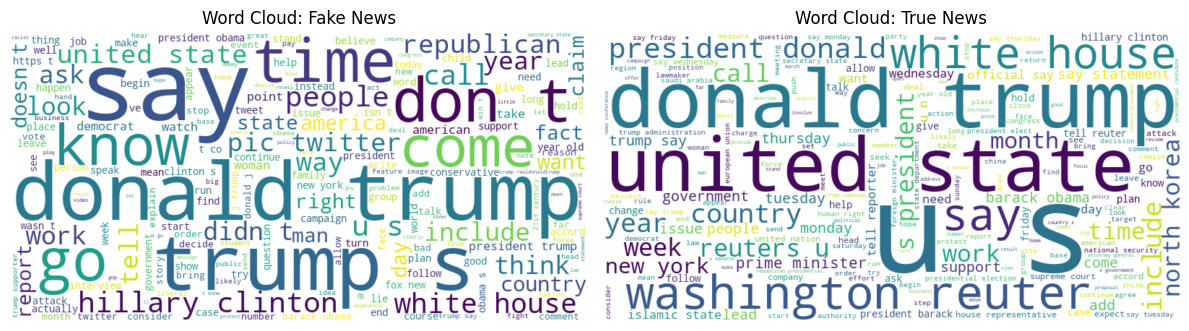

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fusionner les textes traités pour chaque classe
fake_news_text = " ".join(train_data[train_data["label"] == 0]["processed_text"])
true_news_text = " ".join(train_data[train_data["label"] == 1]["processed_text"])

# Générer les word clouds
fake_news_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_news_text)
true_news_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(true_news_text)

# Affichage des word clouds
plt.figure(figsize=(12, 6))

# Word Cloud des fausses nouvelles
plt.subplot(1, 2, 1)
plt.imshow(fake_news_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Fake News")

# Word Cloud des vraies nouvelles
plt.subplot(1, 2, 2)
plt.imshow(true_news_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: True News")

plt.tight_layout()
plt.show()

### Experiments with the proposed model

#### Bag of Words & TF-IDF

##### Prétraitement

In [ ]:
def preprocess_full(text):
    """Prétraitement complet pour les modèles Bag of Words et TF-IDF (avec lemmatisation)."""
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des URLs et handles Twitter
    text = re.sub(r"http\S+|www\S+|@\S+", "", text)
    
    # Suppression de la ponctuation et des espaces supplémentaires
    text = re.sub(r"[^\w\s]", "", text)
    
    # Suppression des espaces blancs supplémentaires
    text = re.sub(r"\s+", " ", text).strip()
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

In [ ]:
def extract_bow_features(X_train, X_test):
    """Extrait les caractéristiques Bag of Words des jeux de données après prétraitement complet."""
    
    # Appliquer le prétraitement complet sur les textes
    X_train_cleaned = [preprocess_full(text) for text in X_train]
    X_test_cleaned = [preprocess_full(text) for text in X_test]
    
    # Initialisation du CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    
    # Transformation des données en matrices BoW
    X_train_bow = vectorizer.fit_transform(X_train_cleaned)
    X_test_bow = vectorizer.transform(X_test_cleaned)
    
    return X_train_bow, X_test_bow

In [ ]:
def extract_tfidf_features(X_train, X_test):
    """Extrait les caractéristiques TF-IDF des jeux de données après prétraitement complet."""
    
    # Appliquer le prétraitement complet sur les textes
    X_train_cleaned = [preprocess_full(text) for text in X_train]
    X_test_cleaned = [preprocess_full(text) for text in X_test]
    
    # Initialisation du TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    
    # Transformation des données en matrices TF-IDF
    X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)
    X_test_tfidf = vectorizer.transform(X_test_cleaned)
    
    return X_train_tfidf, X_test_tfidf

In [21]:
# Diviser les données en ensemble d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer le prétraitement 
X_train_BoW, X_test_BoW = extract_bow_features(X_train, X_test)
X_train_tfidf, X_test_tfidf = extract_tfidf_features(X_train, X_test)

KeyboardInterrupt: 

##### Modèles et évaluation

In [ ]:
def train_with_kfold(X, y, model_type="svm", k=5):
    """Entraîne un modèle avec une validation croisée stratifiée K-Fold et sauvegarde le modèle.""" 
    # Initialisation du modèle en fonction du type
    if model_type == "svm":
        model = SVC(kernel="linear")
    elif model_type == "random_forest":
        model = RandomForestClassifier(n_estimators=100)
    elif model_type == "logistic_regression":
        model = LogisticRegression(max_iter=1000)
    elif model_type == "gradient_boosting":
        model = GradientBoostingClassifier(n_estimators=100)
    elif model_type == "adaboost":
        model = AdaBoostClassifier(n_estimators=100)
    elif model_type == "neural_network":
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)

    # Initialisation du Stratified K-Fold
    y = np.array(y)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Liste pour stocker les scores de chaque fold
    scores = []
    
    # K-Fold Cross Validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Entraîner le modèle sur chaque fold
        model.fit(X_train, y_train)
        
        # Calculer le score (accuracy ici)
        score = model.score(X_test, y_test)
        scores.append(score)
    
    # Afficher les scores moyens et les scores par fold
    print(f"Scores pour chaque fold: {scores}")
    print(f"Score moyen : {np.mean(scores)}")

    # Création du dossier
    os.makedirs("models_BoW", exist_ok=True)

    # Sauvegarde du modèle
    model_filename = f"models_BoW/{model_type}_BoW.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    return model, np.mean(scores)

In [ ]:
# model_ab, mean_scores_ab = train_with_kfold(X_train_tfidf, y_train, model_type="adaboost", k=5)
#7min
model_ab, mean_scores_ab = train_with_kfold(X_train_BoW, y_train, model_type="adaboost", k=5)
#2min

Scores pour chaque fold: [0.9955456570155902, 0.9938752783964365, 0.9951280623608018, 0.9949881665042462, 0.9941528609216205]
Score moyen : 0.994738005039739


In [ ]:
# model_gb = train_with_kfold(X_train_tfidf, y_train, model_type="gradient_boosting", k=5)
#16min
model_gb = train_with_kfold(X_train_BoW, y_train, model_type="gradient_boosting", k=5)
#2min

Scores pour chaque fold: [0.995684855233853, 0.9940144766146993, 0.9947104677060133, 0.9952666016984547, 0.9947097313100376]
Score moyen : 0.9948772265126115


In [ ]:
# model_lr = train_with_kfold(X_train_tfidf, y_train, model_type="logistic_regression", k=5)
#1s
model_lr = train_with_kfold(X_train_BoW, y_train, model_type="logistic_regression", k=5)

Scores pour chaque fold: [0.9972160356347439, 0.9948496659242761, 0.9967984409799554, 0.9955450368926633, 0.9963803424752888]
Score moyen : 0.9961579043813856


In [ ]:
# model_nn = train_with_kfold(X_train_tfidf, y_train, model_type="neural_network", k=5)
#6min
model_nn = train_with_kfold(X_train_BoW, y_train, model_type="neural_network", k=5)
#3min

Scores pour chaque fold: [0.9930400890868597, 0.9916481069042317, 0.9920657015590201, 0.9915077265766393, 0.9930391201447863]
Score moyen : 0.9922601488543075


In [ ]:
# model_rf = train_with_kfold(X_train_tfidf, y_train, model_type="random_forest", k=5)
#6min
model_rf = train_with_kfold(X_train_BoW, y_train, model_type="random_forest", k=5)
#2min

Scores pour chaque fold: [0.9984688195991092, 0.9970768374164811, 0.9981904231625836, 0.9972156480579145, 0.9970764304608103]
Score moyen : 0.9976056317393797


In [ ]:
# model_svm = train_with_kfold(X_train_tfidf, y_train, model_type="svm", k=5)
#10min
model_svm = train_with_kfold(X_train_BoW, y_train, model_type="svm", k=5)
#3min

Scores pour chaque fold: [0.9967984409799554, 0.9958240534521158, 0.995684855233853, 0.9942920785187248, 0.9956842544897675]
Score moyen : 0.9956567365348834


In [ ]:
# Charger et évaluer le modèle
def evaluate_model(X_test, y_test, model_path):
    """Évalue un modèle chargé depuis un fichier."""
    try:
        # Charger le modèle depuis le fichier pickle
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"Erreur : fichier {model_path} introuvable.")
        return

    # Prédiction avec le modèle chargé
    y_pred = model.predict(X_test)

    # Afficher les résultats d'évaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
evaluate_model(X_test_BoW, y_test, "models_BoW/svm_BoW.pkl")

Accuracy: 0.9953229398663697
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4733
           1       0.99      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion Matrix:
 [[4708   25]
 [  17 4230]]


In [ ]:
evaluate_model(X_test_tfidf, y_test, "models_tfidf/svm_tf_idf.pkl")

Accuracy: 0.9932071269487751
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion Matrix:
 [[4697   36]
 [  25 4222]]


#### Word2Vec & BERT & Linguistic Cues

##### Prétraitement

In [3]:
def preprocess_light(text):
    """Prétraitement léger pour les modèles Word2Vec, BERT et Linguistic Cues (sans lemmatisation)."""
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des URLs et handles Twitter
    text = re.sub(r"http\S+|www\S+|@\S+", "", text)
    
    # Suppression de la ponctuation et des espaces supplémentaires
    text = re.sub(r"[^\w\s]", "", text)
    
    # Suppression des espaces blancs supplémentaires
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [4]:
import gensim.downloader as api
from gensim.models import KeyedVectors
import numpy as np

# Charger le modèle Word2Vec (évite de le télécharger à chaque exécution)
try:
    word2vec_model = KeyedVectors.load("word2vec-google-news-300.kv")  # Si déjà téléchargé
except FileNotFoundError:
    word2vec_model = api.load("word2vec-google-news-300")
    word2vec_model.save("word2vec-google-news-300.kv")  # Sauvegarde pour éviter le re-téléchargement

print(f"Word2Vec loaded! Vocab size: {len(word2vec_model.index_to_key)}")

Word2Vec loaded! Vocab size: 3000000


In [5]:
def extract_word2vec_features(X_train, X_test):
    """Extrait les caractéristiques Word2Vec des jeux de données après prétraitement léger."""
    
    def text_to_vec(text):
        """Convertit un texte en un vecteur moyen des embeddings de ses mots."""
        words = text.split()
        vecs = np.array([word2vec_model[word] for word in words if word in word2vec_model])
        return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(word2vec_model.vector_size)
    
    # Appliquer le prétraitement léger et vectoriser en une seule ligne
    X_train_cleaned = [preprocess_light(text) for text in X_train]
    X_test_cleaned = [preprocess_light(text) for text in X_test]
    
    X_train_word2vec = np.array([text_to_vec(text) for text in X_train_cleaned])
    X_test_word2vec = np.array([text_to_vec(text) for text in X_test_cleaned])
    
    return X_train_word2vec, X_test_word2vec

In [66]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\marcd\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\marcd\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [67]:
def extract_bert_features(X_train, X_test, batch_size=32):
    """Extrait les caractéristiques BERT en batch pour améliorer la vitesse."""
    
    def text_to_bert_vec(texts):
        """Convertir une liste de textes en vecteurs BERT (par batch)."""
        inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()

    # Appliquer le prétraitement léger et transformer en batchs
    X_train_cleaned = [preprocess_light(text) for text in X_train]
    X_test_cleaned = [preprocess_light(text) for text in X_test]

    # Traiter en batchs pour accélérer
    X_train_bert = np.vstack([text_to_bert_vec(X_train_cleaned[i:i+batch_size]) for i in range(0, len(X_train_cleaned), batch_size)])
    X_test_bert = np.vstack([text_to_bert_vec(X_test_cleaned[i:i+batch_size]) for i in range(0, len(X_test_cleaned), batch_size)])
    
    return X_train_bert, X_test_bert

In [3]:
def extract_linguistic_cues(X_train, X_test):
    import re
    import numpy as np
    import pandas as pd
    import spacy

    # Charger le modèle spaCy anglais
    nlp = spacy.load("en_core_web_sm")

    def count_words(doc):
        return len([token for token in doc if token.is_alpha])

    def count_syllables(text):
        vowels = "aeiouyAEIOUY"
        return sum([sum(1 for char in word if char in vowels) for word in text.split()])

    def count_sentences(doc):
        return len(list(doc.sents))

    def count_long_words(doc, threshold=6):
        return sum(1 for token in doc if len(token.text) > threshold and token.is_alpha)

    def count_all_caps(doc):
        return sum(1 for token in doc if token.text.isupper())

    def count_unique_words(doc):
        return len(set(token.text.lower() for token in doc if token.is_alpha))

    def count_personal_pronouns(doc):
        pronouns = {'i', 'we', 'she', 'he', 'him', 'me', 'us'}
        return sum(1 for token in doc if token.text.lower() in pronouns)

    def count_articles(doc):
        articles = {'a', 'an', 'the'}
        return sum(1 for token in doc if token.text.lower() in articles)

    def count_pos_tags(doc, pos_tags):
        return sum(1 for token in doc if token.tag_ in pos_tags)

    def count_punctuation(text, p):
        return text.count(p)

    def compute_features(texts):
        features = []
        docs = list(nlp.pipe(texts))
        for doc, text in zip(docs, texts):
            wc = count_words(doc)
            sc = count_sentences(doc)
            data = {
                'word_count': wc,
                'syllables_count': count_syllables(text),
                'sentence_count': sc,
                'words_per_sentence': wc / max(sc, 1),
                'long_words_count': count_long_words(doc),
                'all_caps_count': count_all_caps(doc),
                'unique_words_count': count_unique_words(doc),
                'personal_pronouns%': count_personal_pronouns(doc) / max(wc, 1),
                'articles%': count_articles(doc) / max(wc, 1),
                'prepositions%': count_pos_tags(doc, {'IN'}) / max(wc, 1),
                'auxiliary_verbs%': count_pos_tags(doc, {'VB', 'VBP', 'VBG'}) / max(wc, 1),
                'common_adverbs%': count_pos_tags(doc, {'RB', 'RBR', 'RBS'}) / max(wc, 1),
                'conjunctions%': count_pos_tags(doc, {'CC'}) / max(wc, 1),
                'negations%': count_pos_tags(doc, {'RB'}) / max(wc, 1),
                'common_verbs%': count_pos_tags(doc, {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}) / max(wc, 1),
                'common_adjectives%': count_pos_tags(doc, {'JJ', 'JJR', 'JJS'}) / max(wc, 1),
                'punctuation_count': sum(count_punctuation(text, p) for p in ['.', ',', ':', ';', '!', '?', '-', '(', ')']),
                'full_stop_count': count_punctuation(text, '.'),
                'commas_count': count_punctuation(text, ','),
                'colons_count': count_punctuation(text, ':'),
                'semi_colons_count': count_punctuation(text, ';'),
                'question_marks_count': count_punctuation(text, '?'),
                'exclamation_marks_count': count_punctuation(text, '!'),
                'dashes_count': count_punctuation(text, '-'),
                'apostrophe_count': count_punctuation(text, "'"),
                'brackets_count': count_punctuation(text, '(') + count_punctuation(text, ')')
            }
            features.append(data)
        return pd.DataFrame(features)

    return compute_features(X_train), compute_features(X_test)


In [15]:
X

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
44893    BRUSSELS (Reuters) - NATO allies on Tuesday we...
44894    LONDON (Reuters) - LexisNexis, a provider of l...
44895    MINSK (Reuters) - In the shadow of disused Sov...
44896    MOSCOW (Reuters) - Vatican Secretary of State ...
44897    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 44898, dtype: object

In [4]:
# Diviser les données en ensemble d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer le prétraitement 
#X_train_W2V, X_test_W2V = extract_word2vec_features(X_train, X_test)
# X_train_Bert, X_test_Bert = extract_bert_features(X_train, X_test)
X_train_LC, X_test_LC = extract_linguistic_cues(X_train, X_test)

In [5]:
X_train_LC

,word_count,syllables_count,sentence_count,words_per_sentence,long_words_count,all_caps_count,unique_words_count,personal_pronouns%,articles%,prepositions%,...,punctuation_count,full_stop_count,commas_count,colons_count,semi_colons_count,question_marks_count,exclamation_marks_count,dashes_count,apostrophe_count,brackets_count
0,61,133,3,20.333333,21,2,50,0.000000,0.049180,0.163934,...,9,4,2,0,0,0,0,1,0,2
1,248,474,16,15.500000,60,4,149,0.036290,0.072581,0.137097,...,32,16,10,2,0,0,1,1,0,2
2,490,980,18,27.222222,135,7,258,0.012245,0.081633,0.148980,...,61,25,29,2,0,0,0,3,0,2
3,61,135,2,30.500000,21,3,49,0.000000,0.065574,0.098361,...,8,4,1,0,0,0,0,1,0,2
4,129,252,5,25.800000,29,4,89,0.015504,0.077519,0.193798,...,15,7,3,0,0,0,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35913,0,0,1,0.000000,0,0,0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
35914,706,1429,25,28.240000,205,14,348,0.011331,0.072238,0.144476,...,76,28,20,0,0,0,0,12,0,16
35915,73,134,4,18.250000,17,2,59,0.054795,0.082192,0.082192,...,12,4,3,0,0,0,0,3,0,2
35916,790,1449,46,17.173913,102,14,354,0.024051,0.063291,0.124051,...,164,41,47,3,0,14,4,7,1,48


In [ ]:
# np.save("X_train_W2V.npy", X_train_W2V)
# np.save("X_test_W2V.npy", X_test_W2V)

# np.save("X_train_Bert.npy", X_train_Bert)
# np.save("X_test_Bert.npy", X_test_Bert)

# np.save("X_train_LC.npy", X_train_LC)
# np.save("X_test_LC.npy", X_test_LC)


##### Modèles et évaluation

In [10]:
def train_with_kfold(X, y, model_type="svm", k=5):
    """Entraîne un modèle avec validation croisée stratifiée K-Fold et sauvegarde le modèle.""" 
    from sklearn.model_selection import StratifiedKFold
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neural_network import MLPClassifier
    import numpy as np
    import pickle
    import os

    # Initialisation du modèle en fonction du type
    if model_type == "svm":
        model = LinearSVC(max_iter=10000)
    elif model_type == "random_forest":
        model = RandomForestClassifier(n_estimators=100)
    elif model_type == "logistic_regression":
        model = LogisticRegression(max_iter=1000)
    elif model_type == "gradient_boosting":
        model = GradientBoostingClassifier(n_estimators=100)
    elif model_type == "adaboost":
        model = AdaBoostClassifier(n_estimators=100)
    elif model_type == "neural_network":
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
    else:
        raise ValueError(f"Modèle non reconnu : {model_type}")

    # Assurer que X et y sont bien des pandas DataFrame/Series
    if hasattr(X, "iloc"):
        X_df = X
    else:
        X_df = pd.DataFrame(X)

    if hasattr(y, "iloc"):
        y_series = y
    else:
        y_series = pd.Series(y)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in skf.split(X_df, y_series):
        X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
        y_train, y_test = y_series.iloc[train_index], y_series.iloc[test_index]

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append(score)

    print(f"Scores pour chaque fold: {scores}")
    print(f"Score moyen : {np.mean(scores):.4f}")

    os.makedirs("models_LC", exist_ok=True)
    model_filename = f"models_LC/{model_type}_LC.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    return model, np.mean(scores)


In [11]:
# model_ab, mean_scores_ab = train_with_kfold(X_train_W2V, y_train, model_type="adaboost", k=5)
#53min 0.9395012064491544
model_ab, mean_scores_ab = train_with_kfold(X_train_LC, y_train, model_type="adaboost", k=5)
#2min

Scores pour chaque fold: [0.9387527839643652, 0.9466870824053452, 0.9419543429844098, 0.9386050396770151, 0.9404148684393707]
Score moyen : 0.9413


In [14]:
# model_gb, mean_scores_gb = train_with_kfold(X_train_W2V, y_train, model_type="gradient_boosting", k=5)
#55min 0.9468791150969856
model_gb, mean_scores_gb = train_with_kfold(X_train_LC, y_train, model_type="gradient_boosting", k=5)
#2min

Scores pour chaque fold: [0.9508630289532294, 0.9562917594654788, 0.9508630289532294, 0.9476541834887929, 0.9535013225671725]
Score moyen : 0.9518


In [15]:
# model_lr, mean_scores_lr = train_with_kfold(X_train_W2V, y_train, model_type="logistic_regression", k=5)
#1s 0.9560387919447273
model_lr, mean_scores_lr = train_with_kfold(X_train_LC, y_train, model_type="logistic_regression", k=5)
#2min

/Users/maximechappuis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maximechappuis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Scores pour chaque fold: [0.9078507795100222, 0.91021714922049, 0.9093819599109132, 0.9072810803285535, 0.905471251566198]
Score moyen : 0.9080


/Users/maximechappuis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# model_nn, mean_scores_nn = train_with_kfold(X_train_W2V, y_train, model_type="neural_network", k=5)
#39min 0.984659503678414
model_nn, mean_scores_nn = train_with_kfold(X_train_LC, y_train, model_type="neural_network", k=5)
#2min

Scores pour chaque fold: [0.9510022271714922, 0.9228841870824054, 0.9294265033407573, 0.9426423499930391, 0.9398579980509536]
Score moyen : 0.9372


In [17]:
# model_rf, mean_scores_rf = train_with_kfold(X_train_W2V, y_train, model_type="random_forest", k=5)
#33min 0.9524195142453088
model_rf, mean_scores_rf = train_with_kfold(X_train_LC, y_train, model_type="random_forest", k=5)
#2min

Scores pour chaque fold: [0.9621380846325167, 0.9675668151447662, 0.9636692650334076, 0.960879855213699, 0.9629681191702631]
Score moyen : 0.9634


In [ ]:
# model_svm, mean_scores_svm = train_with_kfold(X_train_W2V, y_train, model_type="svm", k=5)
#3min 0.9691241531058703
model_svm, mean_scores_svm = train_with_kfold(X_train_LC, y_train, model_type="svm", k=5)
#2min

In [12]:
# Charger et évaluer le modèle
def evaluate_model(X_test, y_test, model_path):
    """Évalue un modèle chargé depuis un fichier."""
    try:
        # Charger le modèle depuis le fichier pickle
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"Erreur : fichier {model_path} introuvable.")
        return

    # Prédiction avec le modèle chargé
    y_pred = model.predict(X_test)

    # Afficher les résultats d'évaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [13]:
evaluate_model(X_test_LC, y_test, "models_LC/adaboost_LC.pkl")

Accuracy: 0.9474387527839644
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      4733
           1       0.94      0.95      0.94      4247

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Confusion Matrix:
 [[4466  267]
 [ 205 4042]]


In [20]:
evaluate_model(X_test_LC, y_test, "models_LC/gradient_boosting_LC.pkl")

Accuracy: 0.9569042316258352
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      4733
           1       0.94      0.97      0.95      4247

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980

Confusion Matrix:
 [[4492  241]
 [ 146 4101]]


In [21]:
evaluate_model(X_test_LC, y_test, "models_LC/logistic_regression_LC.pkl")

Accuracy: 0.9065701559020044
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      4733
           1       0.88      0.93      0.90      4247

    accuracy                           0.91      8980
   macro avg       0.91      0.91      0.91      8980
weighted avg       0.91      0.91      0.91      8980

Confusion Matrix:
 [[4189  544]
 [ 295 3952]]


In [22]:
evaluate_model(X_test_LC, y_test, "models_LC/neural_network_LC.pkl")

Accuracy: 0.9410913140311804
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94      4733
           1       0.90      0.99      0.94      4247

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

Confusion Matrix:
 [[4267  466]
 [  63 4184]]


In [23]:
evaluate_model(X_test_LC, y_test, "models_LC/random_forest_LC.pkl")

Accuracy: 0.9661469933184855
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4733
           1       0.97      0.96      0.96      4247

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

Confusion Matrix:
 [[4586  147]
 [ 157 4090]]


In [24]:
evaluate_model(X_test_LC, y_test, "models_LC/svm_LC.pkl")

Erreur : fichier models_LC/svm_LC.pkl introuvable.


### Analysis of results and conclusion

In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import os
import pickle

# Étape 3 : Entraîner et sauvegarder un modèle
def train_model(X_train, y_train, model_type="svm"):
    """Entraîne un modèle classique et sauvegarde le modèle."""
    if model_type == "svm":
        model = SVC(kernel="linear")
    elif model_type == "random_forest":
        model = RandomForestClassifier(n_estimators=100)
    elif model_type == "logistic_regression":
        model = LogisticRegression()
    elif model_type == "gradient_boosting":
        model = GradientBoostingClassifier(n_estimators=100)
    elif model_type == "adaboost":
        model = AdaBoostClassifier(n_estimators=100)
    elif model_type == "neural_network":
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)

    model.fit(X_train, y_train)

    # Création du dossier 'models' s'il n'existe pas
    os.makedirs("models_ntbk", exist_ok=True)

    # Sauvegarde du modèle
    with open(f"models_ntbk/{model_type}.pkl", "wb") as f:
        pickle.dump(model, f)

    return model

# Entraîner un modèle Logistic Regression (par exemple)
model = train_model(X_train_tfidf, y_train, model_type="neural_network")

In [8]:
# Étape 4 : Charger et évaluer le modèle
def evaluate_model(X_test, y_test, model_path):
    """Évalue un modèle chargé depuis un fichier."""
    try:
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"Erreur : fichier {model_path} introuvable.")
        return

    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Évaluer le modèle sur les données de test
evaluate_model(X_test_tfidf, y_test, "models_ntbk/neural_network.pkl")

Accuracy: 0.9902004454342984
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion Matrix:
 [[4697   36]
 [  52 4195]]
